In [3]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import csv
import numpy as np
import os,sys
import PIL # for reading tif images
import h5py
import datetime as dt
import time
from skimage.filters import threshold_otsu

results = "C:\\Networking Experiment\\artiq codes\\artiq-master\\results\\"

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

## 2024.09.06

In [5]:
fnames = get_files_by_criteria(date_filters=["2024-09-09"], # only find files from these date directories
                               name_filters=["Cycler"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)

print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} ({f}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
            else:
                print(f"file {i} ({f}), size = {os.path.getsize(f)/1000:.0f} KB")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 7 files
file 0 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-09\14\000017202-ExperimentCycler.h5), size = 425 KB
file 1 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-09\14\000017204-ExperimentCycler.h5), size = 102 KB
file 2 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-09\15\000017208-ExperimentCycler_atom_loading.h5), size = 324 KB
file 3 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-09\15\000017209-ExperimentCycler.h5), size = 194 KB
file 5 (C:\Networking Experiment\artiq codes\artiq-master\results\2024-09-09\15\000017212-ExperimentCycler.h5), size = 139 KB
skipped 2 redundant files
0 scan_variables over 0 variable scans


In [20]:
def get_piecewise_sequence(sequence_dict):
    sequence_transitions = (len(sequence_dict)-2)*2
    n_points = sequence_transitions + 2
    timestamps = np.zeros(n_points)
    levels =  np.zeros(n_points)
    i = 0
    durations = list(sequence_dict.keys())
    values = list(sequence_dict.values())
    timestamps[i] = durations[0]
    levels[i] = values[0]
    for i in range(1, sequence_transitions):

        if i % 2:
            timestamps[i] = timestamps[i-1]
            levels[i] = levels[i-1]
        else:
            timestamps[i] = timestamps[i-1] + durations[i//2]
            levels[i] = values[i//2]

    levels[-1] = values[-1]
    timestamps[-1] = durations[-1]
    return timestamps, levels

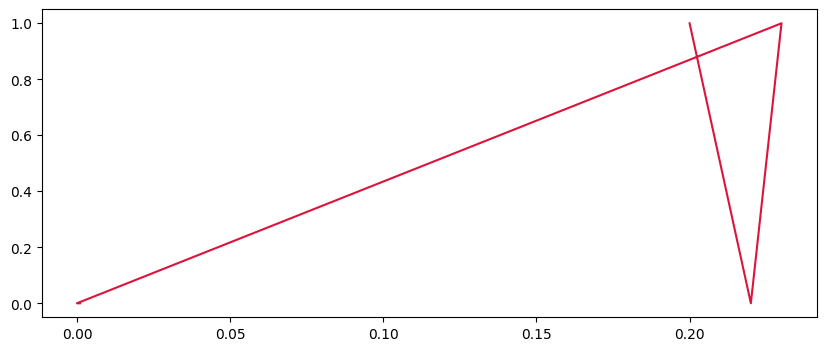

In [21]:
f = h5py.File(os.path.join(results, fnames[5])) # frequency scan with biggest dip around -5 kHz
rid = f['rid'][()]
h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)

cooling_sequence = {t_MOT_loading:1, t_MOT_dissipation:0, t_PGC_in_MOT:1, t_SPCM_first_shot:1, t_delay_between_shots:0, t_SPCM_first_shot:1}

# timestamps, levels = get_piecewise_sequence(cooling_sequence)

sequence_dict = cooling_sequence

sequence_transitions = (len(sequence_dict)-2)*2
n_points = sequence_transitions + 2
timestamps = np.zeros(n_points)
levels =  np.zeros(n_points)

timestamps[0] = 0
levels[0] = values


fig,ax = plt.subplots(nrows=1,figsize=(10,4))
ax.plot(timestamps, levels, color='crimson')

In [22]:
cooling_sequence.keys()

dict_keys([0.2, 0.02, 0.01, 0.015, 0.001])

In [9]:
cooling_sequence.values()

dict_values([1, 0, 1, 1, 0])